#1. Importing the basics for ExtraTrees Classifier
ExtraTreesClassifier is a type of decision tree that builds multiple trees and combines them to make a final prediction, like other tree-based models (e.g., Random Forest). However, what makes it different is the way it builds each tree:

a. **Randomness:**

Unlike regular decision trees, which try to find the best possible split for each feature at each node, ExtraTreesClassifier chooses splits randomly. This makes the model faster and helps reduce overfitting.

b. **Ensemble of Trees:**

Like Random Forest, ExtraTrees combines many trees to make a prediction. The idea is that combining multiple trees can make the model more accurate than using a single tree.

c. **Faster and More Robust:**

Because of the random splits, ExtraTreesClassifier is usually faster to train compared to other decision tree models like CART or Random Forest, and it is also less likely to overfit.

Here, we first import and install necessary stuff that we need to run this specific code.



In [11]:
!pip install optuna
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


#2. Dataset and justification
The Breast Cancer dataset is highly suitable for the ExtraTreesClassifier because it contains complex, nonlinear relationships between biological features that tree-based models can capture effectively.

- Since all features are numeric and continuous, ExtraTrees can easily find optimal split points without needing feature scaling or encoding. However, scaling would still be done as the model must also be good enough for other datasets.

- The dataset’s medium size (569 samples, 30 features) makes it ideal for fast training while still being large enough to demonstrate generalization ability.

- It also contains correlated and redundant features, which ExtraTrees handles well due to its random feature selection and ensemble averaging.

Despite a slight class imbalance, ExtraTrees remains robust and maintains high accuracy, often above 97%, showing strong performance and stability.



In [12]:
from sklearn.datasets import load_breast_cancer
data3 = load_breast_cancer(as_frame=True)
feature_names = data3.feature_names
X, y = load_breast_cancer(return_X_y=True)


# 3. Running code for training prep
Let us begin with the training of our model using the dataset.

## 3.1 Variable assigning, splitting, and stratifying

We assign the relevant variables to the already existing target and non-target columns in the dataset. We stratify the y column as 2 classes with unequal and unbalanced frequencies. Stratifying keeps each class represented in both splits, so the model learns and is tested fairly across all classes—not just the common ones.






In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## 3.2 Finding the best parameters using Optuna

We use a **Optuna** here as it tries every combination we ask of it. It uses cross-validation (train/validate splits) to score each, and picks the best.
With refit=True, it retrains the winner on the entire training data so we get a final model ready for testing. ExtraTreesClassifier builds multiple decision trees using random subsets of the data and features, which helps capture complex patterns in datasets. The key hyperparameters in the model control the structure of these trees. Our target here is to have holistically applicable hyperparameters that will be suitable for any dataset that is pushed into this pipeline.

### 3.2.1 StratifiedKFold()
We used n_splits=3, which cuts the training set into 3 equal folds (A, B, C) while keeping class ratios the same in each fold (that is the “stratified” part). Our dataset classes are unbalanced. Stratification keeps each class represented in every fold, giving fair, stable scores.
We used shuffle=True, which randomizes which rows go into which fold so we get no weird ordering biases.
Again random_state=42 is used so we (and anyone else) get the same random split every run.

###3.2.2 n_estimators (Number of Trees):
This determines how many trees are in the forest. More trees generally improve the model's performance but also increase training time.

- Why/when to use: Between 50-200 trees provide a good balance for datasets like Breast Cancer. More trees generally reduce variance in predictions.
### 3.2.3 max_depth (Maximum Depth of Trees):
Controls how deep each tree can grow. A deeper tree can capture more complex patterns but is more prone to overfitting.
- Why/when to use: A max depth between 10 and 50 is typically enough to avoid overfitting.
### 3.2.4 min_samples_split (Minimum Samples to Split a Node):
This parameter sets the minimum number of samples required to split a node. Larger values result in simpler, more generalized trees.
- Why/when to use: A value between 2 and 10 helps balance model complexity and prevents overfitting by avoiding splits based on very small sample sizes.
### 3.2.5 min_samples_leaf (Minimum Samples per Leaf):
Sets the minimum number of samples required to be at a leaf node. This can help control overfitting by ensuring leaves contain enough data to make reliable predictions.
- Why/when to use: A value between 1 and 5 ensures that each leaf has enough data to make meaningful decisions.
### 3.2.6 max_features (Maximum Features for Splitting):
Controls how many features are considered when making splits in each tree. A smaller number can reduce overfitting and improve generalization.
- Why/when to use: sqrt and log2 are commonly used. This helps the trees become less correlated and more robust.

## 3.3 Creating the Base Pipeline
The pipeline applies StandardScaler first to normalize the features, ensuring each feature has a mean of 0 and a standard deviation of 1. This step is essential because ExtraTreesClassifier does not inherently require feature scaling, but scaling makes the training more stable and ensures that no feature dominates due to differing scales. The classifier (ExtraTreesClassifier) is then fitted to the transformed data.
### 3.3.1 Scaler
StandardScaler() = Normalizes the data by transforming each numeric feature to have a mean of 0 and a standard deviation of 1.
Why: This ensures that features with large or small values do not disproportionately affect model training, providing better stability and performance.
### 3.3.2 Classifier (clf)
"clf", ExtraTreesClassifier() = An ensemble for ETC. The components here are:
- n_estimators: The number of trees to build in the forest. More trees generally improve accuracy but increase computation time.
- max_depth: Limits how deep each tree can grow. This helps avoid overfitting by preventing overly complex trees.
- min_samples_split: The minimum number of samples required to split an internal node. This helps control overfitting by ensuring that nodes are split only when there are enough data points.
- min_samples_leaf: The minimum number of samples required to be at a leaf node. Ensures leaves are not too small, improving model generalization.
- max_features: The number of features to consider when splitting a node. Limiting this can improve model generalization by reducing correlation between trees in the forest.
- random_state=42: Ensures reproducibility of results by setting a fixed random seed.


In [14]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                     min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                     max_features=max_features, random_state=42))
    ])


    score = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()

    return score

# 4. Running the Study
Here we run the study on our already created objectives, where we maximize accuracy. We take 50 trials and keep a progress bar running for ease of viewing.

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-10-24 16:10:24,381] A new study created in memory with name: no-name-2e4e9551-98e2-465a-8c28-aad390365bf1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-24 16:10:29,062] Trial 0 finished with value: 0.9508029332590736 and parameters: {'n_estimators': 134, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9508029332590736.
[I 2025-10-24 16:10:31,382] Trial 1 finished with value: 0.9472848788638263 and parameters: {'n_estimators': 157, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9508029332590736.
[I 2025-10-24 16:10:32,577] Trial 2 finished with value: 0.9596027104799035 and parameters: {'n_estimators': 116, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: 0.9596027104799035.
[I 2025-10-24 16:10:33,738] Trial 3 finished with value: 0.9578483245149911 and parameters: {'n_estimators': 175, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.9596027104799035

# 5. Looking at the best parameters
Let us view the parameters that gave the highest accuracy score on the Optuna study.

In [16]:
print("Best params:", study.best_trial.params)
print("Best Accuracy Score:", study.best_trial.value)
best_params = study.best_trial.params
best_params

Best params: {'n_estimators': 115, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best Accuracy Score: 0.9718926946997121


{'n_estimators': 115,
 'max_depth': 30,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'log2'}

# 6. Training using the best parameters
Using the dictionary made for the best parameters, we fit the model on the train set of our data.

In [17]:
params = study.best_trial.params


best_model = ExtraTreesClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42)

best_model.fit(X_train, y_train)


ExtraTreesClassifier(max_depth=30, max_features='log2', min_samples_split=3,
                     n_estimators=115, random_state=42)

# 7. Results and metrics
We test the model on the test set and look at some metrics to figure out whether our model is good enough. The following are the results:
 ## 7.1: Accuracy
 The model achieved an accuracy of ~95.6%, showing it can correctly classify most breast cancer cases.
 ## 7.2 f1_macro Score
 The macro-F1 score (0.953) is also very high, indicating balanced performance across both malignant (0) and benign (1) classes.
 ## 7.3 Confusion matrix
 Precision and recall are both strong for each class — slightly higher for class 1 (benign), meaning the model is very reliable at correctly identifying non-cancerous cases while still detecting most malignant ones. Since the confusion matrix would show only a few misclassifications, it suggests minimal overfitting and strong generalization.
 ## 7.4 Learning curves
Our ExtraTreesClassifier perfectly fits the training data. That’s expected for tree ensembles like ExtraTrees (they can easily overfit small and simple datasets). Cross-validation score is  ≈ 0.95–0.97 and the validation accuracy is also very high and stable, which means the model generalizes extremely well. The small gap between training and validation curves shows low overfitting. The CV score rises quickly and flattens out, meaning adding more training data wouldn’t change performance much — the model has learned almost everything it can from the dataset.
 ## 7.5 Feature importances
Impactful features vary from each run of the model. But 'worst concave points', 'mean concave points', and 'worst area' consistently come around at the top.

Accuracy: 0.956140350877193
Macro-F1: 0.9526381387619444

Classification report:
               precision    recall  f1-score   support

           0      0.951     0.929     0.940        42
           1      0.959     0.972     0.966        72

    accuracy                          0.956       114
   macro avg      0.955     0.950     0.953       114
weighted avg      0.956     0.956     0.956       114



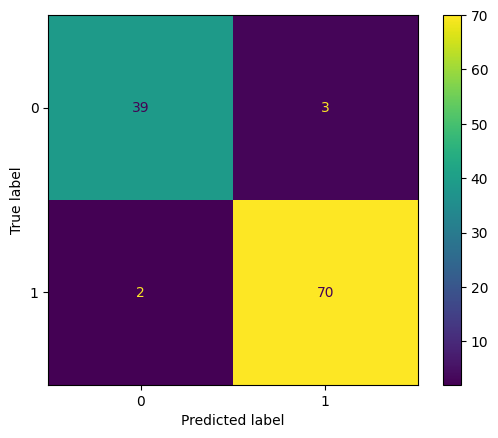

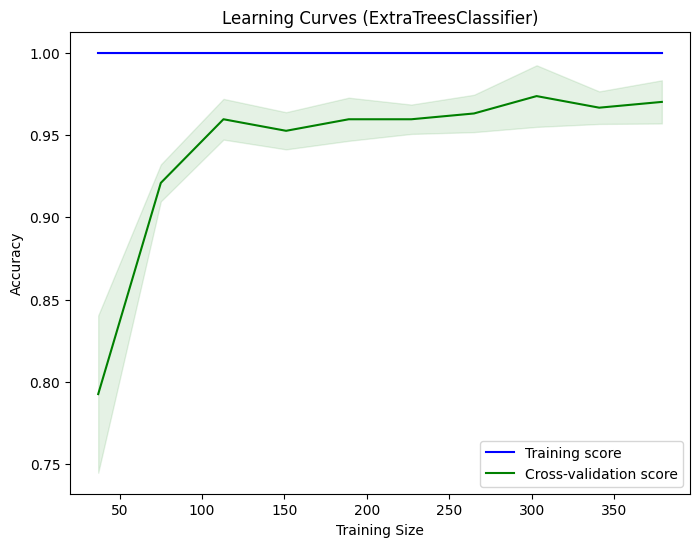

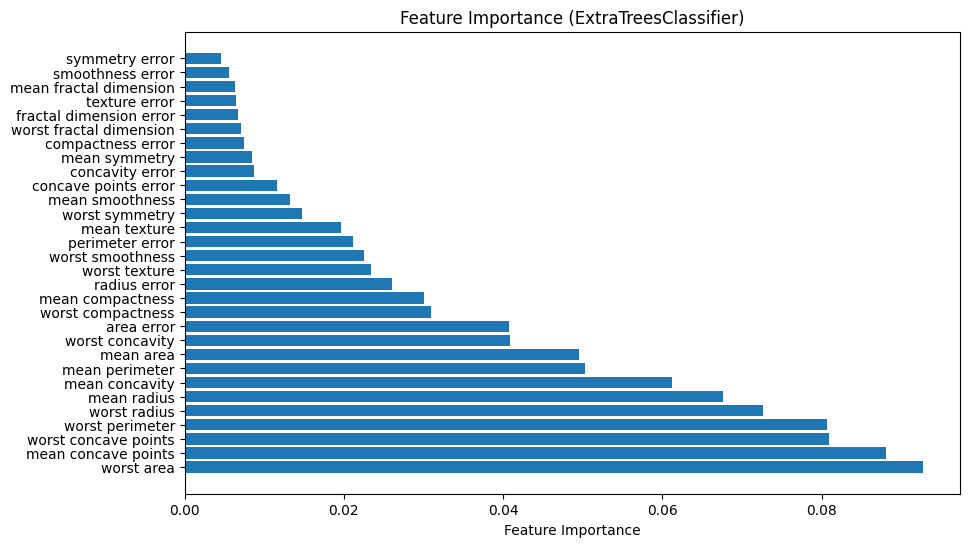

In [18]:

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=cv, n_jobs=-1,
                                                         train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy")
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curves (ExtraTreesClassifier)")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (ExtraTreesClassifier)")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.show()